In [40]:
import sys; sys.path

['/Users/abelsalau/scotiabankfrauddetection',
 '/Users/abelsalau/.vscode/extensions/ms-toolsai.jupyter-2022.11.1003412109/pythonFiles',
 '/Users/abelsalau/.vscode/extensions/ms-toolsai.jupyter-2022.11.1003412109/pythonFiles/lib/python',
 '/Users/abelsalau/opt/anaconda3/lib/python39.zip',
 '/Users/abelsalau/opt/anaconda3/lib/python3.9',
 '/Users/abelsalau/opt/anaconda3/lib/python3.9/lib-dynload',
 '',
 '/Users/abelsalau/opt/anaconda3/lib/python3.9/site-packages',
 '/Users/abelsalau/opt/anaconda3/lib/python3.9/site-packages/aeosa',
 '/Users/abelsalau/opt/anaconda3/lib/python3.9/site-packages/locket-0.2.1-py3.9.egg',
 '/Users/abelsalau/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions',
 '/Users/abelsalau/.ipython']

Imports that we are using

In [41]:
import os 
import warnings

import numpy as np
import tensorflow as tf
import pandas as pd
from pandas import Series, DataFrame
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import decomposition


#visuals
import seaborn as sns
import matplotlib.pyplot as plt


Checking to see that tensorflow works. Your output should contain a tf.tensor

In [42]:
print(tf.reduce_sum(tf.random.normal([1000, 1000])))

tf.Tensor(-189.34421, shape=(), dtype=float32)


Preliminary Graphing

In [43]:
#Loading the dataset - abel
train_url = "https://raw.githubusercontent.com/25ohms/scotiabankfrauddetection/main/Winter%202023%20Discovery%20Days/train_ScotiaDSD.csv"
data = pd.read_csv(train_url)

test_url = "https://raw.githubusercontent.com/25ohms/scotiabankfrauddetection/main/Winter%202023%20Discovery%20Days/test_ScotiaDSD.csv"
test_data = pd.read_csv(test_url)


credible_data = data[data['FRAUD_FLAG'] == 0.0] 
fraudulent_data = data[data['FRAUD_FLAG'] == 1.0]

In [44]:
print(credible_data.head())

   EVENT_MONTH  EVENT_DAY_OF_WEEK EVENT_TIME TRANSACTION_ID  FRAUD_FLAG  \
1            2                  4      12:51       8352728b         0.0   
2            2                  4      15:26       d50120e1         0.0   
3            2                  4      16:19       e96e2139         0.0   
4            2                  4      8:15:       32502a99         0.0   
5            2                  4      16:27       1b4856fb         0.0   

   AVAIL_CRDT  AMOUNT  CREDIT_LIMIT  CARD_NOT_PRESENT  \
1    20371.88   96.35       30700.0                 1   
2    15628.17  193.72       19500.0                 0   
3    12913.98   47.15       18400.0                 0   
4    26779.35  121.88       29200.0                 1   
5    27484.35    6.83       30700.0                 0   

                                          USER_AGENT  ...  \
1  Mozilla/5.0 (iPhone; CPU OS 16_0 like Mac OS X...  ...   
2                                                NaN  ...   
3                      

In [45]:
print(fraudulent_data.head())

     EVENT_MONTH  EVENT_DAY_OF_WEEK EVENT_TIME TRANSACTION_ID  FRAUD_FLAG  \
0              2                  4      14:16       a316accb         1.0   
24             2                  4      20:02       5fcc42f8         1.0   
36             2                  4      19:59       0d060041         1.0   
38             2                  4      12:30       74bbbe44         1.0   
132            2                  4      16:28       c264fb24         1.0   

     AVAIL_CRDT  AMOUNT  CREDIT_LIMIT  CARD_NOT_PRESENT  \
0        537.10   11.70       29200.0                 1   
24      9016.80   50.23       21400.0                 1   
36      3135.47   41.00       19500.0                 1   
38       674.70  161.95        1000.0                 1   
132     1314.30   44.08        5100.0                 1   

                                            USER_AGENT  ...  \
0                                                  NaN  ...   
24   Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:1...  

Checking to see if Data is null

In [46]:
nullcheck = data.drop(['USER_AGENT', 'CITY'], axis=1)
total = nullcheck.isnull().sum().sort_values(ascending = False)
percent = (nullcheck.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,EVENT_MONTH,MAX_PHONE_ORDER_PAST_30DAY,MEAN_TRAVEL_AND_ENTERTAINMENT_PAST_30DAY,MEAN_WEEKEND_PAST_30DAY,MAX_AUTO_PAST_30DAY,MAX_LS_PAST_30DAY,MAX_ELCTRNCS_PAST_30DAY,MAX_FASTFOOD_PAST_30DAY,MAX_HIGH_RECREA_PAST_30DAY,MAX_MANUAL_ENTRY_PAST_30DAY,...,MAX_HIGH_RECREA_PAST_7DAY,MAX_INTERNET_PAST_7DAY,MAX_PHONE_ORDER_PAST_7DAY,MAX_PURCHASE_EXCLUDING_GAS_PAST_7DAY,MAX_SWIPE_PAST_7DAY,MAX_WEEKEND_PAST_7DAY,STD_LX_PAST_7DAY,PREV_M_UNEMP_RATE,CITY,USER_AGENT
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [47]:
num_fraudulent = fraudulent_data.shape[0]
num_total = data.shape[0]

p_fraudulent = num_fraudulent / num_total
print(p_fraudulent)

0.024139863274683402


Suggests that the data is heavily unbalanced.

In [48]:
print(data.shape)

(89230, 175)


/section{Using PCA on Data}

In [49]:
response_train = data['FRAUD_FLAG']
numerical_train = data.drop(['EVENT_MONTH', 'EVENT_DAY_OF_WEEK','EVENT_TIME','TRANSACTION_ID', 
    'FRAUD_FLAG','CARD_NOT_PRESENT', 
      'USER_AGENT', 'CITY', 'FLAG_LX', 'FLAG_ATM', 'FLAG_AUTO', 'FLAG_CASH',
      'FLAG_LS', 'FLAG_DISCOUNT', 'FLAG_RECREA', 'FLAG_ELCTRNCS', 'FLAG_REG_AMT',
      'FLAG_FASTFOOD', 'FLAG_GAS', 'FLAG_HIGH_AMT', 'FLAG_HIGH_RECREA', 'FLAG_INTERNET',
      'FLAG_INTERNATIONAL', 'FLAG_JEWELRY', 'FLAG_LOW_AMT', 'FLAG_MANUAL_ENTRY',
      'FLAG_PHONE_ORDER', 'FLAG_PURCHASE_EXCLUDING_GAS', 'FLAG_PLANNED', 'FLAG_RISKY',
      'FLAG_SWIPE', 'FLAG_TRAVEL_ONLY', 'FLAG_TRAVEL_AND_ENTERTAINMENT', 'FLAG_WEEKEND'], axis=1)

numerical_test = test_data.drop(['EVENT_MONTH', 'EVENT_DAY_OF_WEEK','EVENT_TIME','TRANSACTION_ID', 
    'FRAUD_FLAG','CARD_NOT_PRESENT', 
      'USER_AGENT', 'CITY', 'FLAG_LX', 'FLAG_ATM', 'FLAG_AUTO', 'FLAG_CASH',
      'FLAG_LS', 'FLAG_DISCOUNT', 'FLAG_RECREA', 'FLAG_ELCTRNCS', 'FLAG_REG_AMT',
      'FLAG_FASTFOOD', 'FLAG_GAS', 'FLAG_HIGH_AMT', 'FLAG_HIGH_RECREA', 'FLAG_INTERNET',
      'FLAG_INTERNATIONAL', 'FLAG_JEWELRY', 'FLAG_LOW_AMT', 'FLAG_MANUAL_ENTRY',
      'FLAG_PHONE_ORDER', 'FLAG_PURCHASE_EXCLUDING_GAS', 'FLAG_PLANNED', 'FLAG_RISKY',
      'FLAG_SWIPE', 'FLAG_TRAVEL_ONLY', 'FLAG_TRAVEL_AND_ENTERTAINMENT', 'FLAG_WEEKEND'], axis=1)  

bernoulli_catergorical_train = data[['EVENT_MONTH', 'EVENT_DAY_OF_WEEK','EVENT_TIME','TRANSACTION_ID', 'CARD_NOT_PRESENT', 
      'USER_AGENT', 'CITY', 'FLAG_LX', 'FLAG_ATM', 'FLAG_AUTO', 'FLAG_CASH',
      'FLAG_LS', 'FLAG_DISCOUNT', 'FLAG_RECREA', 'FLAG_ELCTRNCS', 'FLAG_REG_AMT',
      'FLAG_FASTFOOD', 'FLAG_GAS', 'FLAG_HIGH_AMT', 'FLAG_HIGH_RECREA', 'FLAG_INTERNET',
      'FLAG_INTERNATIONAL', 'FLAG_JEWELRY', 'FLAG_LOW_AMT', 'FLAG_MANUAL_ENTRY',
      'FLAG_PHONE_ORDER', 'FLAG_PURCHASE_EXCLUDING_GAS', 'FLAG_PLANNED', 'FLAG_RISKY',
      'FLAG_SWIPE', 'FLAG_TRAVEL_ONLY', 'FLAG_TRAVEL_AND_ENTERTAINMENT', 'FLAG_WEEKEND']]

bernoulli_catergorical_test = test_data[['EVENT_MONTH', 'EVENT_DAY_OF_WEEK','EVENT_TIME','TRANSACTION_ID', 'CARD_NOT_PRESENT', 
      'USER_AGENT', 'CITY', 'FLAG_LX', 'FLAG_ATM', 'FLAG_AUTO', 'FLAG_CASH',
      'FLAG_LS', 'FLAG_DISCOUNT', 'FLAG_RECREA', 'FLAG_ELCTRNCS', 'FLAG_REG_AMT',
      'FLAG_FASTFOOD', 'FLAG_GAS', 'FLAG_HIGH_AMT', 'FLAG_HIGH_RECREA', 'FLAG_INTERNET',
      'FLAG_INTERNATIONAL', 'FLAG_JEWELRY', 'FLAG_LOW_AMT', 'FLAG_MANUAL_ENTRY',
      'FLAG_PHONE_ORDER', 'FLAG_PURCHASE_EXCLUDING_GAS', 'FLAG_PLANNED', 'FLAG_RISKY',
      'FLAG_SWIPE', 'FLAG_TRAVEL_ONLY', 'FLAG_TRAVEL_AND_ENTERTAINMENT', 'FLAG_WEEKEND']]   
         
print(response_train.head())
print(numerical_train.head())

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: FRAUD_FLAG, dtype: float64
   AVAIL_CRDT  AMOUNT  CREDIT_LIMIT  MEAN_AUTO_PAST_7DAY  MEAN_LS_PAST_7DAY  \
0      537.10   11.70       29200.0                46.65               0.00   
1    20371.88   96.35       30700.0                 0.00               0.00   
2    15628.17  193.72       19500.0                 0.00               0.00   
3    12913.98   47.15       18400.0                23.40             123.58   
4    26779.35  121.88       29200.0                 4.61               0.00   

   MEAN_RECREA_PAST_7DAY  MEAN_REG_AMT_PAST_7DAY  MEAN_FASTFOOD_PAST_7DAY  \
0                1600.03                  158.88                     0.00   
1                   0.00                  243.75                     0.00   
2                 113.26                 2305.18                    22.55   
3                  66.91                   78.00                     0.00   
4                   0.00                    0.00              

In [50]:
print(bernoulli_catergorical_train.head())

   EVENT_MONTH  EVENT_DAY_OF_WEEK EVENT_TIME TRANSACTION_ID  CARD_NOT_PRESENT  \
0            2                  4      14:16       a316accb                 1   
1            2                  4      12:51       8352728b                 1   
2            2                  4      15:26       d50120e1                 0   
3            2                  4      16:19       e96e2139                 0   
4            2                  4      8:15:       32502a99                 1   

                                          USER_AGENT      CITY  FLAG_LX  \
0                                                NaN       NaN        0   
1  Mozilla/5.0 (iPhone; CPU OS 16_0 like Mac OS X...   lasalle        0   
2                                                NaN       NaN        0   
3                                                NaN       NaN        0   
4  Mozilla/5.0 (iPhone; CPU OS 16_0 like Mac OS X...  rockland        0   

   FLAG_ATM  FLAG_AUTO  ...  FLAG_LOW_AMT  FLAG_MANUAL_ENTRY  

In [51]:
standarized_data = StandardScaler().fit_transform(numerical_train)
pca = decomposition.PCA(n_components=28)
pca_data = pca.fit_transform(standarized_data)
print(pca_data)


[[24.98518745 -1.50530662 -0.71863378 ... -2.66700995 -0.83250785
  -4.98163795]
 [ 5.04899104 -1.68724601 -3.31085767 ... -1.07934748  0.0254616
  -0.31401387]
 [14.02284563  2.84140927 -7.279466   ... -0.42031676  0.65449847
   0.3624304 ]
 ...
 [-3.97972847  2.80988124 -0.79004063 ...  0.19921296 -0.35450274
   0.05434611]
 [ 0.52679896  0.14917994 -1.52204225 ... -0.387044   -0.63323161
   1.28450515]
 [ 1.9506017  -1.88979052  2.0856306  ...  1.22381372 -0.07606875
  -0.10203465]]


/subsection{Scree Plot}
Determining number of factors we wish to use in our exploratory factor analysis to keep in a PCA.

Text(0, 0.5, 'Retention value on scale of 1')

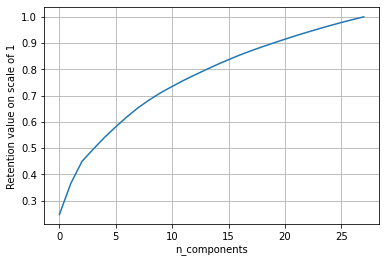

In [52]:
pca.n_components = 141

retention_value = pca.explained_variance_ / np.sum(pca.explained_variance_);
cumulative_retention = np.cumsum(retention_value)

plt.plot(cumulative_retention)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Retention value on scale of 1')

In [53]:
print(pca_data.shape)

(89230, 28)


In [54]:
print(bernoulli_catergorical_train.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89230 entries, 0 to 89229
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   EVENT_MONTH                    89230 non-null  int64 
 1   EVENT_DAY_OF_WEEK              89230 non-null  int64 
 2   EVENT_TIME                     89230 non-null  object
 3   TRANSACTION_ID                 89230 non-null  object
 4   CARD_NOT_PRESENT               89230 non-null  int64 
 5   USER_AGENT                     11908 non-null  object
 6   CITY                           11908 non-null  object
 7   FLAG_LX                        89230 non-null  int64 
 8   FLAG_ATM                       89230 non-null  int64 
 9   FLAG_AUTO                      89230 non-null  int64 
 10  FLAG_CASH                      89230 non-null  int64 
 11  FLAG_LS                        89230 non-null  int64 
 12  FLAG_DISCOUNT                  89230 non-null  int64 
 13  F

/subsubsection{Label Encoding Bernoulli/Categorical Data}

In [55]:
label_encoder = LabelEncoder()
bernoulli_catergorical_train['CITY'] = label_encoder.fit_transform(bernoulli_catergorical_train['CITY'])
bernoulli_catergorical_train['USER_AGENT'] = label_encoder.fit_transform(bernoulli_catergorical_train['CITY'])
bernoulli_catergorical_train['EVENT_TIME'] = label_encoder.fit_transform(bernoulli_catergorical_train['EVENT_TIME'])
bernoulli_catergorical_train['TRANSACTION_ID'] = label_encoder.fit_transform(bernoulli_catergorical_train['TRANSACTION_ID'])

print(bernoulli_catergorical_train.info(verbose=True))


bernoulli_catergorical_test['CITY'] = label_encoder.fit_transform(bernoulli_catergorical_test['CITY'])
bernoulli_catergorical_test['USER_AGENT'] = label_encoder.fit_transform(bernoulli_catergorical_test['CITY'])
bernoulli_catergorical_test['EVENT_TIME'] = label_encoder.fit_transform(bernoulli_catergorical_test['EVENT_TIME'])
bernoulli_catergorical_test['TRANSACTION_ID'] = label_encoder.fit_transform(bernoulli_catergorical_test['TRANSACTION_ID'])

print(bernoulli_catergorical_test.info(verbose=True))


/var/folders/mb/f4gp43lj3klc_j3wky81g9hw0000gn/T/ipykernel_29002/287048299.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bernoulli_catergorical_train['CITY'] = label_encoder.fit_transform(bernoulli_catergorical_train['CITY'])
/var/folders/mb/f4gp43lj3klc_j3wky81g9hw0000gn/T/ipykernel_29002/287048299.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bernoulli_catergorical_train['USER_AGENT'] = label_encoder.fit_transform(bernoulli_catergorical_train['CITY'])
/var/folders/mb/f4gp43lj3klc_j3wky81g9hw00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89230 entries, 0 to 89229
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   EVENT_MONTH                    89230 non-null  int64
 1   EVENT_DAY_OF_WEEK              89230 non-null  int64
 2   EVENT_TIME                     89230 non-null  int64
 3   TRANSACTION_ID                 89230 non-null  int64
 4   CARD_NOT_PRESENT               89230 non-null  int64
 5   USER_AGENT                     89230 non-null  int64
 6   CITY                           89230 non-null  int64
 7   FLAG_LX                        89230 non-null  int64
 8   FLAG_ATM                       89230 non-null  int64
 9   FLAG_AUTO                      89230 non-null  int64
 10  FLAG_CASH                      89230 non-null  int64
 11  FLAG_LS                        89230 non-null  int64
 12  FLAG_DISCOUNT                  89230 non-null  int64
 13  FLAG_RECREA     

/var/folders/mb/f4gp43lj3klc_j3wky81g9hw0000gn/T/ipykernel_29002/287048299.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bernoulli_catergorical_test['TRANSACTION_ID'] = label_encoder.fit_transform(bernoulli_catergorical_test['TRANSACTION_ID'])
